# Import libraries And Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re
import nltk
import json
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
np.random.seed(42)

from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

import librosa
import librosa.display
from scipy.signal import periodogram

CPU times: user 1.37 s, sys: 345 ms, total: 1.71 s
Wall time: 2.68 s


# Import Data and Audio

In [3]:
folderpath = "/content/drive/MyDrive/Colab Notebooks/BUET BioMed"
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BUET BioMed/train_df_sorted.csv")
train_df_meta = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BUET BioMed/additional_metadata.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BUET BioMed/test_files.csv")

print("train data shape: ",train_df.shape)
print("train extra data shape: ", train_df_meta.shape)
print("test data shape: ",test_df.shape)

train data shape:  (59, 15)
train extra data shape:  (59, 5)
test data shape:  (49, 9)


In [4]:
train_df.drop("patient_num", axis=1, inplace=True)
train_df.head(5)

,patient_id,AS,AR,MR,MS,N,recording_1,recording_2,recording_3,recording_4,recording_5,recording_6,recording_7,recording_8
0,patient_002,0,0,1,0,0,002_sup_Mit,002_sup_Tri,002_sup_Pul,002_sup_Aor,002_sit_Mit,002_sit_Tri,002_sit_Pul,002_sit_Aor
1,patient_004,0,0,1,0,0,004_sup_Mit,004_sup_Tri,004_sup_Pul,004_sup_Aor,004_sit_Mit,004_sit_Tri,004_sit_Pul,004_sit_Aor
2,patient_006,0,0,0,1,0,006_sup_Mit,006_sup_Tri,006_sup_Pul,006_sup_Aor,006_sit_Mit,006_sit_Tri,006_sit_Pul,006_sit_Aor
3,patient_010,0,0,1,0,0,010_sup_Mit,010_sup_Tri,010_sup_Pul,010_sup_Aor,010_sit_Mit,010_sit_Tri,010_sit_Pul,010_sit_Aor
4,patient_011,0,0,1,0,0,011_sup_Mit,011_sup_Tri,011_sup_Pul,011_sup_Aor,011_sit_Mit,011_sit_Tri,011_sit_Pul,011_sit_Aor


In [5]:
print(f"AS value Counts *\n{train_df['AS'].value_counts()}")
print(f"MS value Counts *\n{train_df['MS'].value_counts()}")
print(f"AR value Counts *\n{train_df['AR'].value_counts()}")
print(f"MR value Counts *\n{train_df['MR'].value_counts()}")
print(f"N value Counts *\n{train_df['N'].value_counts()}")

AS value Counts *
0    40
1    19
Name: AS, dtype: int64
MS value Counts *
0    36
1    23
Name: MS, dtype: int64
AR value Counts *
0    38
1    21
Name: AR, dtype: int64
MR value Counts *
0    36
1    23
Name: MR, dtype: int64
N value Counts *
0    47
1    12
Name: N, dtype: int64


In [6]:
train_df_meta.head()

,patient_id,Age,Gender,Smoker,Lives
0,patient_002,37,M,1,U
1,patient_004,21,M,0,R
2,patient_006,35,M,1,U
3,patient_010,26,F,0,R
4,patient_011,46,F,0,R


In [7]:
gender_mapping = {'M': 0, 'F': 1}
train_df_meta['Gender'] = train_df_meta['Gender'].map(gender_mapping)
lives_mapping = {'U' : 0, 'R' : 1}
train_df_meta['Lives'] = train_df_meta['Lives'].map(lives_mapping)
display(train_df_meta.head())
print(train_df_meta['Gender'].value_counts())
print(train_df_meta['Smoker'].value_counts())
print(train_df_meta['Lives'].value_counts())

,patient_id,Age,Gender,Smoker,Lives
0,patient_002,37,0,1,0
1,patient_004,21,0,0,1
2,patient_006,35,0,1,0
3,patient_010,26,1,0,1
4,patient_011,46,1,0,1


0    34
1    25
Name: Gender, dtype: int64
0    38
1    21
Name: Smoker, dtype: int64
0    31
1    28
Name: Lives, dtype: int64


In [8]:
test_df.head(5)

,patient_id,recording_1,recording_2,recording_3,recording_4,recording_5,recording_6,recording_7,recording_8
0,patient_001,001_sit_Aor,001_sit_Mit,001_sit_Pul,001_sit_Tri,001_sup_Aor,001_sup_Mit,001_sup_Pul,001_sup_Tri
1,patient_003,003_sit_Aor,003_sit_Mit,003_sit_Pul,003_sit_Tri,003_sup_Aor,003_sup_Mit,003_sup_Pul,003_sup_Tri
2,patient_005,005_sit_Aor,005_sit_Mit,005_sit_Pul,005_sit_Tri,005_sup_Aor,005_sup_Mit,005_sup_Pul,005_sup_Tri
3,patient_007,007_sit_Aor,007_sit_Mit,007_sit_Pul,007_sit_Tri,007_sup_Aor,007_sup_Mit,007_sup_Pul,007_sup_Tri
4,patient_008,008_sit_Aor,008_sit_Mit,008_sit_Pul,008_sit_Tri,008_sup_Aor,008_sup_Mit,008_sup_Pul,008_sup_Tri


In [9]:
file_path = folderpath+"/train audio/002_sup_Tri.wav"

# Load audio file
audio_data, sample_rate = librosa.load(file_path)
audio_data = np.array(audio_data)

print("Audio data shape:", audio_data.shape)
print("Audio data:", audio_data)
print("Sample rate:", sample_rate)
print("Audio length: ", len(audio_data)/sample_rate)

Audio data shape: (441000,)
Audio data: [-1.1920929e-06 -2.6524067e-06 -4.0531158e-06 ...  1.5461205e-02
  9.9067166e-03  4.7827223e-03]
Sample rate: 22050
Audio length:  20.0


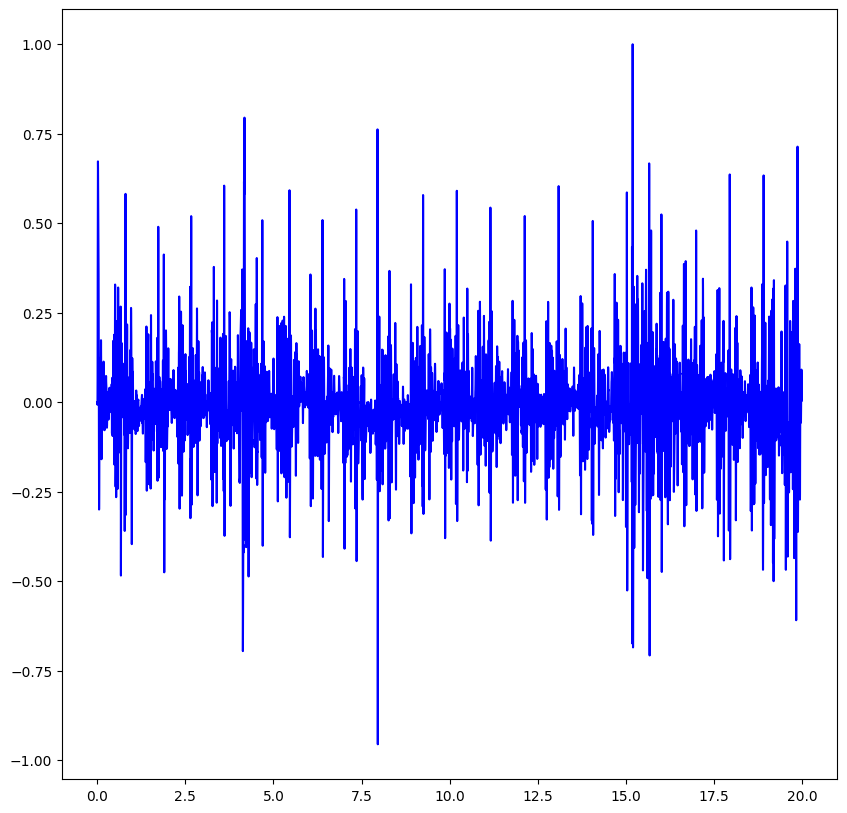

In [10]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(0,20,len(audio_data)),audio_data,color='blue')
plt.show()

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

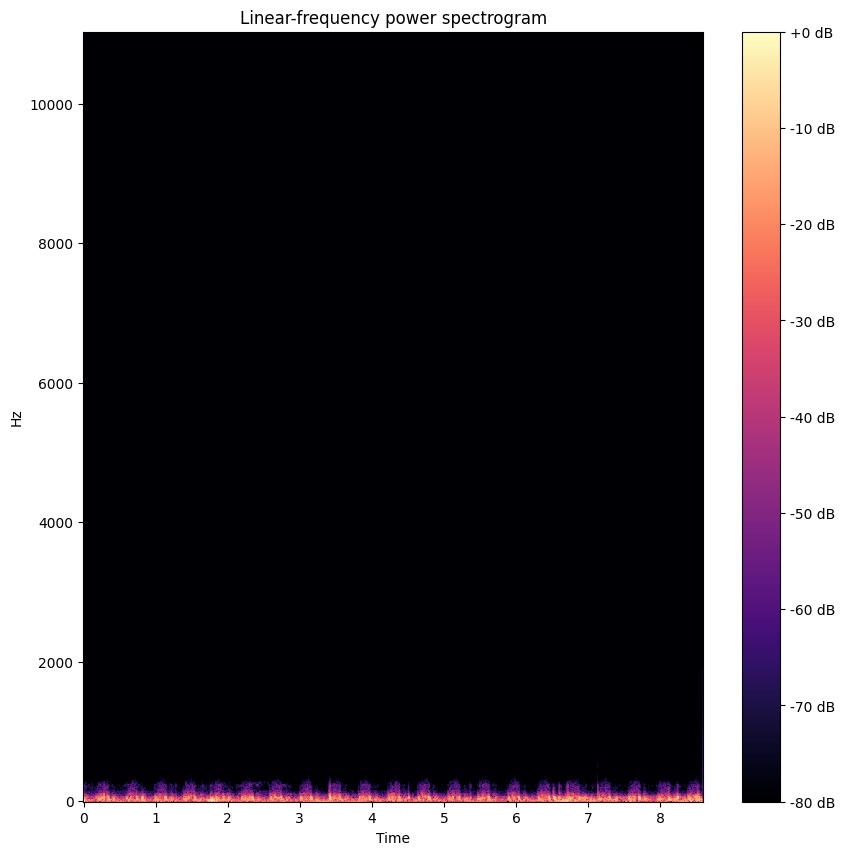

In [11]:
hop_length = int(sample_rate * 0.01)

plt.figure(figsize=(10, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
librosa.display.specshow(D, y_axis='linear', sr=sample_rate, hop_length=hop_length, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

## Fetch All Audios

### MFCC Features

In [14]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.4 MB/s eta 0:00:00


In [21]:
def features_extractor(file):

  y, sr = librosa.load(file, sr=16000)
  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
  delta_mfccs = librosa.feature.delta(mfccs)
  delta2_mfccs = librosa.feature.delta(mfccs, order=2)
  zcr = librosa.feature.zero_crossing_rate(y)
  centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
  bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
  nyquist_freq = sr / 2
  max_fmin = nyquist_freq / 2
  max_n_bands = int(nyquist_freq / 200)
  contrast = librosa.feature.spectral_contrast(y=y, sr=sr, fmin=min(100.0, max_fmin), n_bands=min(6, max_n_bands))

  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
  chroma = librosa.feature.chroma_stft(y=y, sr=sr)

  # Compute mean of each feature across time
  mfccs_mean = np.mean(mfccs.T, axis=0)
  delta_mfccs_mean = np.mean(delta_mfccs.T, axis=0)
  delta2_mfccs_mean = np.mean(delta2_mfccs.T, axis=0)
  zcr_mean = np.mean(zcr.T, axis=0)
  centroid_mean = np.mean(centroid.T, axis=0)
  bandwidth_mean = np.mean(bandwidth.T, axis=0)
  contrast_mean = np.mean(contrast.T, axis=0)
  rolloff_mean = np.mean(rolloff.T, axis=0)
  chroma_mean = np.mean(chroma.T, axis=0)

  # Concatenate all features into a single feature vector
  all_features = np.concatenate([mfccs_mean, delta_mfccs_mean, delta2_mfccs_mean,
                               zcr_mean, centroid_mean, bandwidth_mean,
                               contrast_mean, rolloff_mean, chroma_mean])
  return all_features

In [22]:
train_data = []
for row in range(train_df.shape[0]):
    patient_frames = []
    for col in range(6, train_df.shape[1]):
        file_name = train_df.iloc[row,col] + ".wav"
        file_path = folderpath + "/train audio/" + file_name
        frames = features_extractor(file_path)
        patient_frames.append(frames)
    train_data.append(patient_frames)
train_data = np.array(train_data)

In [23]:
print(train_data.shape)

(59, 8, 143)


In [24]:
train_data = train_data.reshape(59,-1)
print(train_data.shape)
print(train_data)

(59, 1144)
[[-459.04962158   46.43867874   44.90584564 ...    0.71099466
     0.75537992    0.78208321]
 [-466.52575684   42.01420593   40.98769379 ...    0.73743552
     0.7645818     0.77862978]
 [-483.09310913   47.39717484   45.86192703 ...    0.71545619
     0.74108976    0.75253969]
 ...
 [-475.14486694   35.73046112   34.70003128 ...    0.71697086
     0.77835834    0.80784512]
 [-479.25289917   39.22848511   37.68255615 ...    0.77943486
     0.81859523    0.83563972]
 [-459.87850952   41.04857254   39.70827866 ...    0.84730428
     0.87801588    0.89152426]]


In [25]:
test_data = []
for row in range(test_df.shape[0]):
    patient_frames = []
    for col in range(1, test_df.shape[1]):
        file_name = test_df.iloc[row,col] + ".wav"
        file_path = folderpath + "/test audio/" + file_name
        frames = features_extractor(file_path)
        patient_frames.append(frames)
    test_data.append(patient_frames)
test_data = np.array(test_data)

In [26]:
print(test_data.shape)

(49, 8, 143)


In [27]:
test_data = test_data.reshape(49,-1)
print(test_data.shape)
print(train_data)

(49, 1144)
[[-459.04962158   46.43867874   44.90584564 ...    0.71099466
     0.75537992    0.78208321]
 [-466.52575684   42.01420593   40.98769379 ...    0.73743552
     0.7645818     0.77862978]
 [-483.09310913   47.39717484   45.86192703 ...    0.71545619
     0.74108976    0.75253969]
 ...
 [-475.14486694   35.73046112   34.70003128 ...    0.71697086
     0.77835834    0.80784512]
 [-479.25289917   39.22848511   37.68255615 ...    0.77943486
     0.81859523    0.83563972]
 [-459.87850952   41.04857254   39.70827866 ...    0.84730428
     0.87801588    0.89152426]]


In [28]:
print(test_data)

[[-476.12930298   44.12120438   42.9155159  ...    0.66677707
     0.7124306     0.76781845]
 [-434.55709839   39.10295868   38.08365631 ...    0.80334818
     0.81998366    0.82933879]
 [-432.89337158   39.92664719   38.81631851 ...    0.80119717
     0.81423962    0.82117754]
 ...
 [-434.55032349   48.00159836   46.4156456  ...    0.84757853
     0.86037946    0.8637867 ]
 [-439.82189941   59.26745987   56.37532425 ...    0.8032822
     0.82778734    0.83114958]
 [-486.01907349   67.08882141   62.53298569 ...    0.79214144
     0.80167311    0.80488759]]


### Train-Test Split

In [29]:
X = train_data
Y = train_df[['AS','AR','MR','MS','N']]
Y = Y.values
X_test = test_data
print(X.shape)
print(Y.shape)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.15, random_state=42)

print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)

(59, 1144)
(59, 5)
Training data shape: (50, 1144) (50, 5)
Validation data shape: (9, 1144) (9, 5)


In [30]:
print(X_train)

[[-448.43170166   37.25605392   36.12372208 ...    0.76169163
     0.78936911    0.79534686]
 [-452.39920044   45.86308289   44.31991196 ...    0.74642897
     0.82373965    0.86539006]
 [-454.90289307   54.97527695   52.96466827 ...    0.81567502
     0.83772439    0.83899796]
 ...
 [-450.26248169   42.11301804   40.92119598 ...    0.72241211
     0.78183615    0.81408018]
 [-430.97793579   54.49453354   51.70023727 ...    0.84060532
     0.86913681    0.87342399]
 [-457.35562134   44.1084671    42.7943573  ...    0.77465534
     0.80805749    0.81802827]]


In [31]:
print(y_train)

[[0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 1 1 0 0]
 [1 1 1 1 0]
 [0 0 1 1 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 1 0 0 0]
 [0 0 0 0 1]
 [0 0 1 1 0]
 [0 0 0 0 1]
 [0 1 1 0 0]
 [1 1 0 1 0]
 [0 1 0 0 0]
 [1 1 0 0 0]
 [1 0 0 1 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 1 1 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 1 1 0]
 [1 0 1 0 0]
 [1 1 0 0 0]
 [1 1 1 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 1 1 1 0]
 [1 1 0 1 0]
 [1 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 1 1 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 1 0]
 [0 0 0 1 0]
 [1 1 1 1 0]
 [0 0 1 1 0]
 [0 1 1 0 0]
 [0 0 0 0 1]
 [0 0 1 1 0]]


In [32]:
print(y_train.shape)
print(type(y_train))

(50, 5)
<class 'numpy.ndarray'>


In [33]:
print(X_train.shape)

(50, 1144)


# ML Models

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier

## DT

In [36]:
base_classifier = DecisionTreeClassifier(max_depth= None, random_state= 42)

classifier = MultiOutputClassifier(base_classifier)
classifier.fit(train_data, Y)
Y_pred = classifier.predict(test_data)

In [37]:
print(Y_pred)

[[0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 1 0]
 [0 1 0 1 0]
 [1 0 0 0 0]
 [0 1 1 0 0]
 [0 0 0 0 0]
 [0 0 0 1 1]
 [1 1 0 0 0]
 [0 0 0 0 0]
 [1 1 1 1 0]
 [0 1 0 1 0]
 [1 0 0 0 0]
 [0 1 1 0 0]
 [1 0 0 1 0]
 [0 0 0 1 1]
 [1 1 1 0 0]
 [0 0 1 1 1]
 [0 0 1 1 0]
 [0 1 1 0 1]
 [0 1 1 1 1]
 [1 0 0 1 0]
 [0 1 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [1 0 1 0 0]
 [1 1 1 1 0]
 [0 0 1 0 0]
 [0 0 1 1 0]
 [0 1 1 0 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 1 0]
 [0 0 0 0 0]
 [1 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 1 0]
 [0 0 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]
 [0 1 0 1 0]
 [0 0 0 1 0]
 [0 1 1 0 1]
 [0 1 1 0 0]
 [0 0 1 1 0]]


In [38]:
column_names = ['AS', 'AR', 'MR', 'MS', 'N']
y_pred = pd.DataFrame(Y_pred, columns=column_names)
y_pred.insert(0, 'patient_id', test_df['patient_id'])
y_pred.to_csv("DTstride.csv", index=False)

In [39]:
y_pred.head()

,patient_id,AS,AR,MR,MS,N
0,patient_001,0,1,0,0,0
1,patient_003,0,0,1,0,0
2,patient_005,0,1,0,1,0
3,patient_007,0,1,0,1,0
4,patient_008,1,0,0,0,0


## RF

In [40]:
rf_base_classifier = RandomForestClassifier(n_estimators = 100, max_depth = 2, random_state = 42)
rf_classifier = MultiOutputClassifier(rf_base_classifier)
rf_classifier.fit(X, Y)

MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=2,
                                                       random_state=42))

In [41]:
y_pred_rf = rf_classifier.predict(test_data)

In [42]:
y_pred_rf

array([[1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0,

In [43]:
column_names = ['AS', 'AR', 'MR', 'MS', 'N']
y_pred = pd.DataFrame(y_pred_rf, columns=column_names)
y_pred.insert(0, 'patient_id', test_df['patient_id'])
y_pred.to_csv("RFstride.csv", index=False)

In [44]:
y_pred.head()

,patient_id,AS,AR,MR,MS,N
0,patient_001,1,0,0,0,0
1,patient_003,0,0,0,0,0
2,patient_005,0,0,0,0,0
3,patient_007,1,0,0,0,0
4,patient_008,0,0,0,0,0


## LR

In [45]:
lr_base_classifier = LogisticRegression(solver = 'liblinear', max_iter = 100, random_state = 42)
lr_classifier = MultiOutputClassifier(lr_base_classifier)
lr_classifier.fit(X, Y)
y_pred_lr = lr_classifier.predict(test_data)

In [46]:
y_pred_lr

array([[1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0],
       [1, 0, 0,

In [47]:
column_names = ['AS', 'AR', 'MR', 'MS', 'N']
y_pred = pd.DataFrame(y_pred_lr, columns=column_names)
y_pred.insert(0, 'patient_id', test_df['patient_id'])
y_pred.to_csv("LRstride.csv", index=False)

In [48]:
y_pred.head()

,patient_id,AS,AR,MR,MS,N
0,patient_001,1,1,0,0,0
1,patient_003,0,0,1,0,0
2,patient_005,1,0,1,0,0
3,patient_007,0,0,0,0,0
4,patient_008,0,0,1,0,0


## XGB

In [49]:
xgb_base_classifier = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 3, random_state = 42 )
xgb_classifier = MultiOutputClassifier(xgb_base_classifier)
xgb_classifier.fit(X, Y)

MultiOutputClassifier(estimator=GradientBoostingClassifier(random_state=42))

In [50]:
y_pred_xgb = xgb_classifier.predict(test_data)

In [51]:
y_pred_xgb

array([[1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0],
       [1, 0, 1, 0, 0],
       [0, 0, 0, 1, 1],
       [1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [0, 1, 0, 0, 1],
       [0, 1, 1, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1,

In [52]:
column_names = ['AS', 'AR', 'MR', 'MS', 'N']
y_pred = pd.DataFrame(y_pred_xgb, columns=column_names)
y_pred.insert(0, 'patient_id', test_df['patient_id'])
y_pred.to_csv("XGBstride.csv", index=False)

In [53]:
y_pred.head()

,patient_id,AS,AR,MR,MS,N
0,patient_001,1,0,0,0,0
1,patient_003,1,0,1,0,0
2,patient_005,1,0,0,0,0
3,patient_007,1,0,1,0,0
4,patient_008,1,0,0,0,0


## Ensemble

In [54]:
# Ensemble of Decision Tree, Random Forest, and Logistic Regression
ensemble_classifier = VotingClassifier(estimators=[
    ('decision_tree', base_classifier),
    ('random_forest', rf_base_classifier),
    ('logistic_regression', lr_base_classifier)
], voting='hard')
ensemble_classifier = MultiOutputClassifier(ensemble_classifier)
ensemble_classifier.fit(X, Y)

y_pred_ensemble = ensemble_classifier.predict(test_data)

In [55]:
y_pred_ensemble

array([[1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0,

In [56]:
column_names = ['AS', 'AR', 'MR', 'MS', 'N']
y_pred = pd.DataFrame(y_pred_ensemble, columns=column_names)
y_pred.insert(0, 'patient_id', test_df['patient_id'])
y_pred.to_csv("Ensemblestride.csv", index=False)

In [57]:
y_pred.head()

,patient_id,AS,AR,MR,MS,N
0,patient_001,1,1,0,0,0
1,patient_003,0,0,1,0,0
2,patient_005,0,0,0,0,0
3,patient_007,0,0,0,0,0
4,patient_008,0,0,0,0,0


# DL Models

## ANN

In [58]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D

In [60]:
num_labels = 5

model = Sequential()

model.add(Dense(100, input_shape=(1144,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('sigmoid'))

learning_rate = 0.0005
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['binary_accuracy'])

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               114500    
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [62]:
num_epochs = 100
num_batch_size = 8

checkpointer = ModelCheckpoint(filepath='audio_DNN.h5', verbose=1, save_best_only=True)
model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[checkpointer], verbose=1)


Epoch 1/100
1/7 [===>..........................] - ETA: 7s - loss: 31.4811 - binary_accuracy: 0.5750
Epoch 1: val_loss improved from inf to 4.50785, saving model to audio_DNN.h5
7/7 [==============================] - 2s 71ms/step - loss: 22.6462 - binary_accuracy: 0.5200 - val_loss: 4.5079 - val_binary_accuracy: 0.5111
Epoch 2/100
1/7 [===>..........................] - ETA: 0s - loss: 16.8484 - binary_accuracy: 0.5000
Epoch 2: val_loss improved from 4.50785 to 4.17691, saving model to audio_DNN.h5
7/7 [==============================] - 0s 22ms/step - loss: 14.1319 - binary_accuracy: 0.5280 - val_loss: 4.1769 - val_binary_accuracy: 0.5778
Epoch 3/100
1/7 [===>..........................] - ETA: 0s - loss: 13.2697 - binary_accuracy: 0.5750
Epoch 3: val_loss improved from 4.17691 to 2.90286, saving model to audio_DNN.h5
7/7 [==============================] - 0s 22ms/step - loss: 13.5302 - binary_accuracy: 0.5080 - val_loss: 2.9029 - val_binary_accuracy: 0.6444
Epoch 4/100
1/7 [===>........

In [63]:
model = load_model('audio_DNN.h5')
yy_pred = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [64]:
yy_pred

array([[0.36486778, 0.4166675 , 0.42896745, 0.4065329 , 0.25971094],
       [0.36486778, 0.4166675 , 0.42896745, 0.4065329 , 0.25971094],
       [0.36486778, 0.4166675 , 0.42896745, 0.4065329 , 0.25971094],
       [0.36486778, 0.4166675 , 0.42896745, 0.4065329 , 0.25971094],
       [0.36486778, 0.4166675 , 0.42896745, 0.4065329 , 0.25971094],
       [0.36486778, 0.4166675 , 0.42896745, 0.4065329 , 0.25971094],
       [0.36486778, 0.4166675 , 0.42896745, 0.4065329 , 0.25971094],
       [0.36486778, 0.4166675 , 0.42896745, 0.4065329 , 0.25971094],
       [0.36486778, 0.4166675 , 0.42896745, 0.4065329 , 0.25971094],
       [0.36486778, 0.4166675 , 0.42896745, 0.4065329 , 0.25971094],
       [0.36486778, 0.4166675 , 0.42896745, 0.4065329 , 0.25971094],
       [0.36486778, 0.4166675 , 0.42896745, 0.4065329 , 0.25971094],
       [0.36486778, 0.4166675 , 0.42896745, 0.4065329 , 0.25971094],
       [0.36486778, 0.4166675 , 0.42896745, 0.4065329 , 0.25971094],
       [0.36486778, 0.4166675 , 0.

In [65]:
threshold = 0.4
yy_pred[yy_pred > threshold] = 1
yy_pred[yy_pred <= threshold] = 0
yy_pred = yy_pred.astype(int)
print(yy_pred)

[[0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]]


In [66]:
column_names = ['AS', 'AR', 'MR', 'MS', 'N']
y_pred = pd.DataFrame(yy_pred, columns=column_names)
y_pred.insert(0, 'patient_id', test_df['patient_id'])
y_pred.to_csv("DLsubmission.csv", index=False)

## CNN

In [68]:
num_labels = 5

model = Sequential()

model.add(Conv1D(32, 3, input_shape=(1144,1)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 3))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(128, 3))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(256, 3))
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('sigmoid'))


learning_rate = 0.0005
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['binary_accuracy'])

In [69]:
num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='audio_CNN.h5', verbose=1, save_best_only=True)
model.fit(train_data, Y, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[checkpointer], verbose=1)

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 16.8299 - binary_accuracy: 0.5356
Epoch 1: val_loss improved from inf to 6.71989, saving model to audio_CNN.h5
2/2 [==============================] - 6s 1s/step - loss: 16.8299 - binary_accuracy: 0.5356 - val_loss: 6.7199 - val_binary_accuracy: 0.6222
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 14.3561 - binary_accuracy: 0.6169
Epoch 2: val_loss improved from 6.71989 to 1.15956, saving model to audio_CNN.h5
2/2 [==============================] - 1s 397ms/step - loss: 14.3561 - binary_accuracy: 0.6169 - val_loss: 1.1596 - val_binary_accuracy: 0.6222
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 9.1187 - binary_accuracy: 0.4712
Epoch 3: val_loss did not improve from 1.15956
2/2 [==============================] - 1s 277ms/step - loss: 9.1187 - binary_accuracy: 0.4712 - val_loss: 1.2228 - val_binary_accuracy: 0.4444
Epoch 4/100
2/2 [==============================] - ETA: 0s - loss

In [70]:
model = load_model('audio_CNN.h5')

y_predCNN = model.predict(X_test)

print(y_predCNN)

2/2 [==============================] - 0s 27ms/step
[[0.4761386  0.34554893 0.4526607  0.5532945  0.51269144]
 [0.47704527 0.34252372 0.45339704 0.5540012  0.5160516 ]
 [0.47592205 0.33681256 0.4567451  0.55799705 0.51993525]
 [0.47465345 0.34614503 0.45414877 0.54855865 0.51352733]
 [0.47563967 0.33638266 0.4536675  0.554532   0.5186382 ]
 [0.47323033 0.33730736 0.45489672 0.5535272  0.5167071 ]
 [0.47641945 0.33915433 0.4554771  0.5541999  0.5175405 ]
 [0.47792128 0.33878744 0.4543384  0.55771726 0.51896715]
 [0.47732124 0.34084335 0.45307115 0.5516841  0.51802623]
 [0.48426956 0.344419   0.45293427 0.55322134 0.5226573 ]
 [0.4797847  0.34222597 0.45653364 0.5545643  0.51836383]
 [0.4778122  0.34216246 0.45530674 0.55358535 0.5188328 ]
 [0.4739234  0.34488788 0.45665443 0.5519757  0.51438546]
 [0.4767512  0.34480196 0.45650527 0.5530198  0.5170774 ]
 [0.47729865 0.34667188 0.4533413  0.55290204 0.51391864]
 [0.47792238 0.34318274 0.45870006 0.5556952  0.5202811 ]
 [0.48122147 0.34593

In [71]:
threshold = 0.46
y_predCNN[y_predCNN > threshold] = 1
y_predCNN[y_predCNN <= threshold] = 0
y_predCNN = y_predCNN.astype(int)
print(y_predCNN)

[[1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]
 [1 0 0 1 1]]


In [72]:
column_names = ['AS', 'AR', 'MR', 'MS', 'N']
y_predCNN = pd.DataFrame(y_predCNN, columns=column_names)
y_predCNN.insert(0, 'patient_id', test_df['patient_id'])
y_predCNN.to_csv("CNNsubmission.csv", index=False)